# Clustering & sub-clustering example

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## 1.   Loading the Dataframe with pandas ->

In [13]:
pd.set_option("display.max.rows", 10)
pd.set_option("display.max.columns", 43)
missing_values = ["N/a", "na", np.nan] # Those are treated as 'NaN' as well

#? To get rid of the warning that shows up
dtype_dict = {
    '_id': int,
    'Area_of_Origin': str,
    'Building_Status': str,
    'Business_Impact': str,
    'Civilian_Casualties': float,
    'Count_of_Persons_Rescued': float,
    'Estimated_Dollar_Loss': float,
    'Estimated_Number_Of_Persons_Displaced': float,
    'Exposures': float,
    'Ext_agent_app_or_defer_time': str,
    'Extent_Of_Fire': str,
    'Final_Incident_Type': str,
    'Fire_Alarm_System_Impact_on_Evacuation': str,
    'Fire_Alarm_System_Operation': str,
    'Fire_Alarm_System_Presence': str,
    'Fire_Under_Control_Time': str,
    'Ignition_Source': str,
    'Incident_Number': str,
    'Incident_Station_Area': str,
    'Incident_Ward': float,
    'Initial_CAD_Event_Type': str,
    'Intersection': str,
    'Last_TFS_Unit_Clear_Time': str,
    'Latitude': float,
    'Level_Of_Origin': str,
    'Longitude': float,
    'Material_First_Ignited': str,
    'Method_Of_Fire_Control': str,
    'Number_of_responding_apparatus': float,
    'Number_of_responding_personnel': float,
    'Possible_Cause': str,
    'Property_Use': str,
    'Smoke_Alarm_at_Fire_Origin': str,
    'Smoke_Alarm_at_Fire_Origin_Alarm_Failure': str,
    'Smoke_Alarm_at_Fire_Origin_Alarm_Type': str,
    'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation': str,
    'Smoke_Spread': str,
    'Sprinkler_System_Operation': str,
    'Sprinkler_System_Presence': str,
    'Status_of_Fire_On_Arrival': str,
    'TFS_Alarm_Time': str,
    'TFS_Arrival_Time': str,
    'TFS_Firefighter_Casualties': float
}
###---
# dataset url: https://open.toronto.ca/dataset/fire-incidents/
df = pd.read_csv("Fire Incidents Data.csv", dtype=dtype_dict, na_values=missing_values)

#? Size: 29425 rows × 43 columns

## 2. Pre-processing / Cleaning the Data ->

In [14]:
columns_to_drop = [
    'Area_of_Origin', 'Building_Status', 'Business_Impact', 'Extent_Of_Fire', 'Final_Incident_Type',
    'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation',
    'Ignition_Source', 'Incident_Station_Area', 'Initial_CAD_Event_Type', 'Intersection',
    'Level_Of_Origin', 'Material_First_Ignited', 'Method_Of_Fire_Control', 'Property_Use',
    'Smoke_Alarm_at_Fire_Origin', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure', 'Smoke_Alarm_at_Fire_Origin_Alarm_Type',
    'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation', 'Smoke_Spread', 'Sprinkler_System_Operation',
    'Status_of_Fire_On_Arrival', 'Exposures']
df.dropna(how="all", inplace=True)
df.drop(columns=columns_to_drop, inplace=True)
df.drop_duplicates(keep="first", inplace=True)

#? Going to drop rows where Latitude and Longtitude are 0/NaN because I won't need them.
#* Longitude = Geographical length of nearest major or minor intersection in the ward of the incident
#* Latitude = Geographical width of the nearest major or minor intersection in the periphery of the incident
df = df.dropna(subset=['Latitude', 'Longitude'])
df = df[(df['Latitude'] != 0) & (df['Longitude'] != 0)]
df = df[df['Possible_Cause'] != '99 - Undetermined']
#---

# Handling dates
datetime_columns = ['TFS_Alarm_Time', 'Fire_Under_Control_Time', 'TFS_Arrival_Time', 'Last_TFS_Unit_Clear_Time']
for col in datetime_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

## 3. Using the elbow method to find the optimal 'k' ->

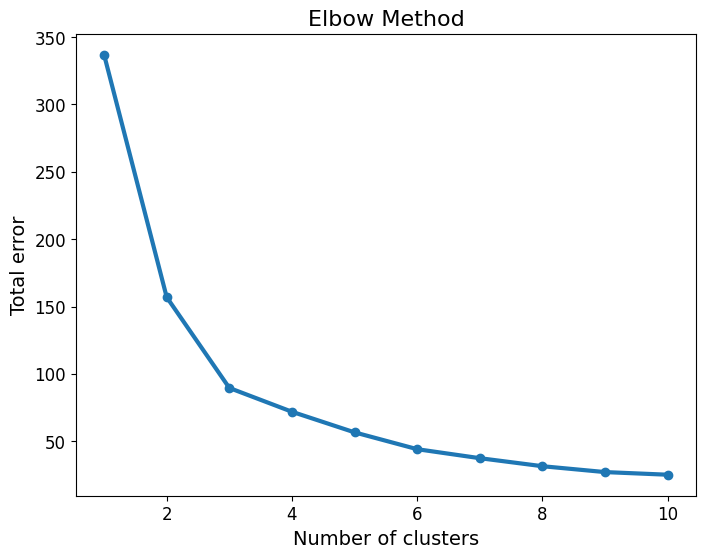

In [15]:
#? Calculate total error for different numbers of clusters with K-Means
err_total = []
n_clusters = 10
df_elbow = df[['Latitude', 'Longitude']]

for i in range(1, n_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_elbow)
    err_total.append(kmeans.inertia_)

# Plot elbow method
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(1, n_clusters + 1), err_total, linewidth=3, marker='o')
ax.set_xlabel("Number of clusters", fontsize=14)
ax.set_ylabel("Total error", fontsize=14)
ax.set_title("Elbow Method", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

- *Based on the Elbow method, I can see that the "elbow" is formed on the number 3 hence I am going to use k = 3.

## 4. Executing k-Means with `k = 3` ->

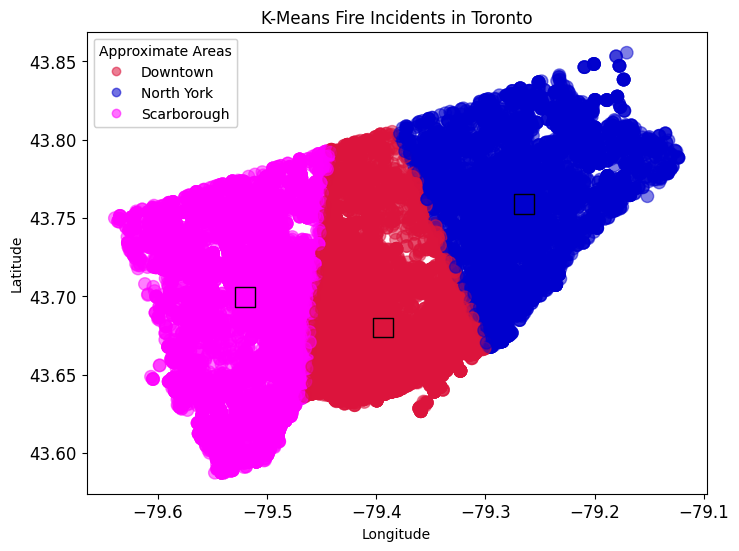

In [16]:
#? This Dataset contains Latitude values from [42 to 45] and Longitude from [-80 to -76] 
#? Based on google: 
# Downtown Toronto is approximate at: 43.6400 to 43.6544 Latitude / -79.3802 to -79.3802 Longtitude
# North York Toronto is approximate at: 43.65 to 43.80 Latitude / -79.40 to -79.30 Longtitude
# Scarborough Toronto is approximate at: 43.65 to 43.85 Latitude / -79.20 to -79.10 Longtitude
# So I will map each cluster with it's corresponding area name by creating another column

kmeans = KMeans(n_clusters=3, random_state=0)
df['Locations_Cluster'] = kmeans.fit_predict(df[['Latitude', 'Longitude']])
centroids = kmeans.cluster_centers_

# Map clusters to location names
cluster_labels = {
    0: 'Downtown',
    1: 'North York',
    2: 'Scarborough'
}
df['Location_Name'] = df['Locations_Cluster'].map(cluster_labels)
#? 2 new columns added thhat contain clustering info
#---

# Plot clusters
fig, ax = plt.subplots(figsize=(8, 6))
customcmap = ListedColormap(["crimson", "mediumblue", "magenta"])
scatter = ax.scatter(df['Longitude'], df['Latitude'], c=df['Locations_Cluster'], cmap=customcmap, s=80, alpha=0.5)
ax.scatter(centroids[:, 1], centroids[:, 0], marker='s', s=200, c=[0, 1, 2], cmap=customcmap, edgecolor='black')
ax.set_title('K-Means Fire Incidents in Toronto')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
handles, _ = scatter.legend_elements()
labels = [cluster_labels[i] for i in range(3)]
legend1 = ax.legend(handles, labels, title="Approximate Areas")
ax.add_artist(legend1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


## 5 Creating Dataframes based on the Location Clusters
### 5.1 Applying elbow method again ->

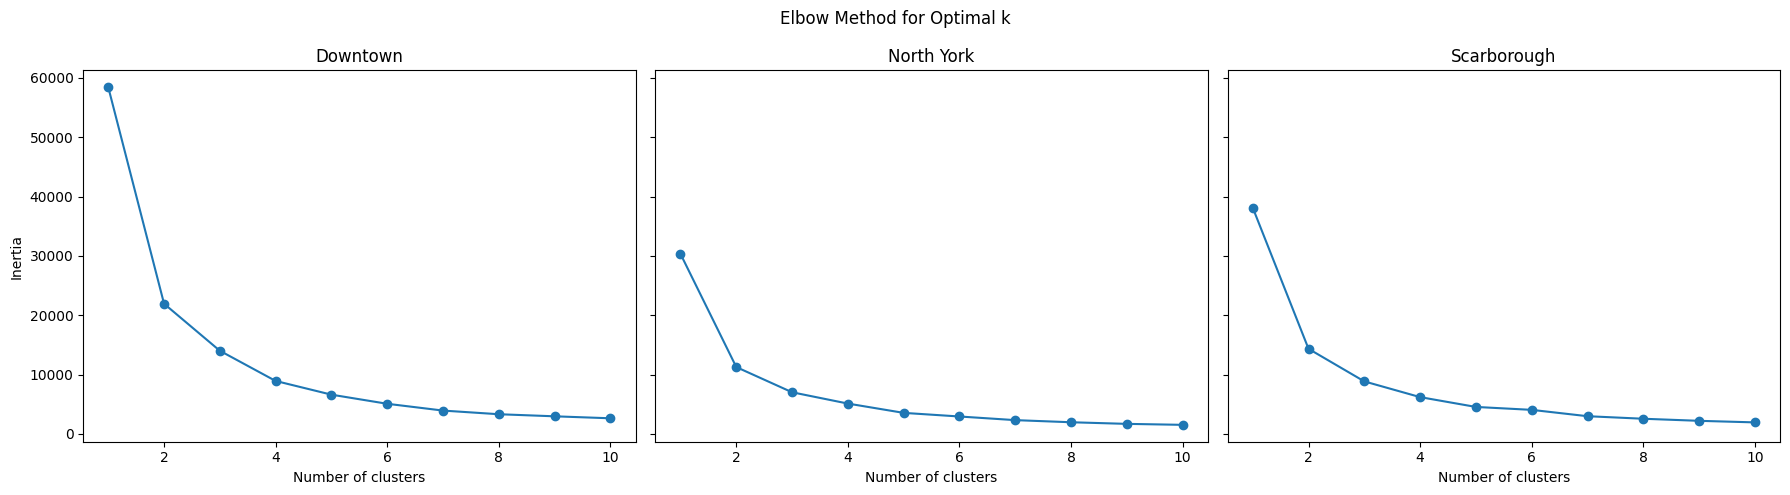

In [17]:
def calc_elbow_method(data, datetime_columns, cause_column, max_clusters=10):
    
    data = data.copy()
    # Finding the min time then adding a new column for each date-time column
    # that contains the present "date - the min time" as hours in numeric format
    for col in datetime_columns:
        earliest_time = data[col].min()
        data.loc[:, col + '_numeric'] = (data[col] - earliest_time) / pd.Timedelta(hours=1)
    
    # Encode the categorical data, 'Possible_Cause' column into distinct numerical values
    le = LabelEncoder()
    data.loc[:, cause_column + '_encoded'] = le.fit_transform(data[cause_column].astype(str))
    processed_cols = [col + '_numeric' for col in datetime_columns] + [cause_column + '_encoded']
    
    # Fills missing values with median
    imputer = SimpleImputer(strategy='median')
    data_imputed = imputer.fit_transform(data[processed_cols])
    
    # Scaling the data to remove outliers
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_imputed)
    
    # Calculate inertia for different number of clusters
    inertia_values = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(data_scaled)
        inertia_values.append(kmeans.inertia_)
    
    return inertia_values
#---

#? Dataframes based on location clustering
downtown_df = df[df['Location_Name'] == 'Downtown']
north_york_df = df[df['Location_Name'] == 'North York']
scarborough_df = df[df['Location_Name'] == 'Scarborough']
#---

#? Applying elbow method to find optimal k
elbow_downtown_df = calc_elbow_method(downtown_df, datetime_columns, 'Possible_Cause')
elbow_north_york_df = calc_elbow_method(north_york_df, datetime_columns, 'Possible_Cause')
elbow_scarborough_df = calc_elbow_method(scarborough_df, datetime_columns, 'Possible_Cause')
#---

# Plotting the elbows
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle('Elbow Method for Optimal k')

axes[0].plot(range(1, len(elbow_downtown_df) + 1), elbow_downtown_df, marker='o')
axes[0].set_title('Downtown')
axes[0].set_xlabel('Number of clusters')
axes[0].set_ylabel('Inertia')

axes[1].plot(range(1, len(elbow_north_york_df) + 1), elbow_north_york_df, marker='o')
axes[1].set_title('North York')
axes[1].set_xlabel('Number of clusters')

axes[2].plot(range(1, len(elbow_scarborough_df) + 1), elbow_scarborough_df, marker='o')
axes[2].set_title('Scarborough')
axes[2].set_xlabel('Number of clusters')

plt.tight_layout()
plt.show()

### 5.2 Sub-Clustering based on Timestamps ->

In [18]:
def perform_kmeans_clustering(data, datetime_columns, cause_column, k):
    
    data = data.copy()
    for col in datetime_columns:
        earliest_time = data[col].min()
        data[col + '_numeric'] = (data[col] - earliest_time) / pd.Timedelta(hours=1)
        
    le = LabelEncoder()
    data[cause_column + '_encoded'] = le.fit_transform(data[cause_column])
    
    processed_cols = [col + '_numeric' for col in datetime_columns] + [cause_column + '_encoded']

    imputer = SimpleImputer(strategy='median')
    data_imputed = imputer.fit_transform(data[processed_cols])
    
    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=0)
    data['Cluster'] = kmeans.fit_predict(data_imputed)
    
    return data, kmeans.cluster_centers_
#---

# Perform KMeans clustering on each dataset
downtown_df, downtown_centers = perform_kmeans_clustering(downtown_df, datetime_columns, 'Possible_Cause', 3)
north_york_df, north_york_centers = perform_kmeans_clustering(north_york_df, datetime_columns, 'Possible_Cause', 3)
scarborough_df, scarborough_centers = perform_kmeans_clustering(scarborough_df, datetime_columns, 'Possible_Cause', 3)

## 6. Possible Cause of fire incidents analysis on each area by cluster ->

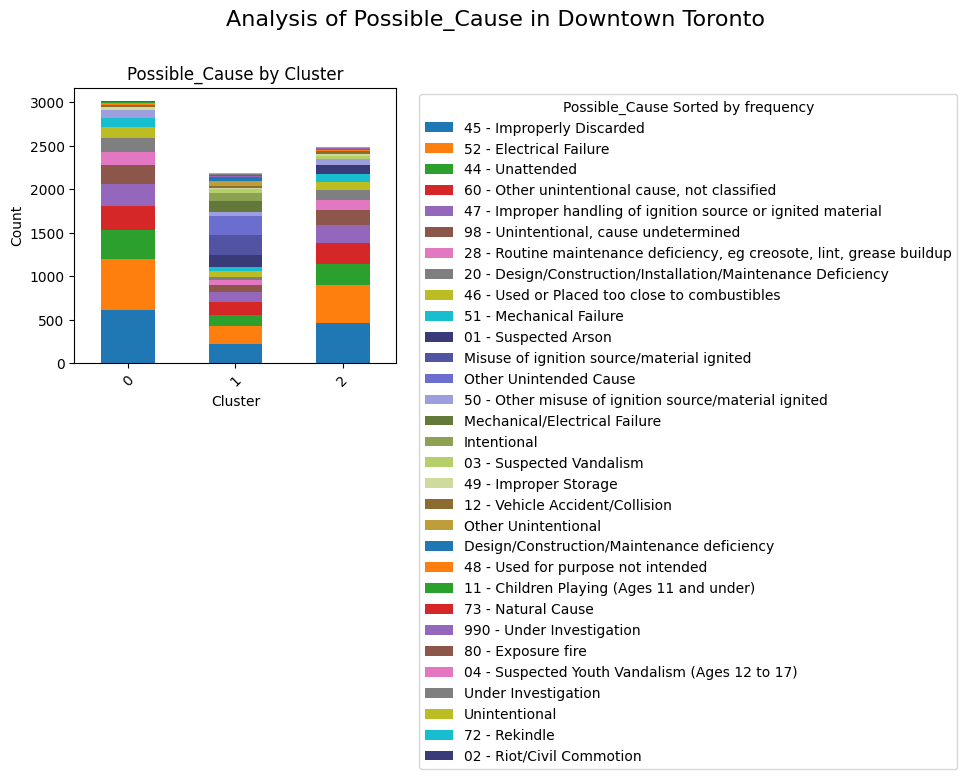

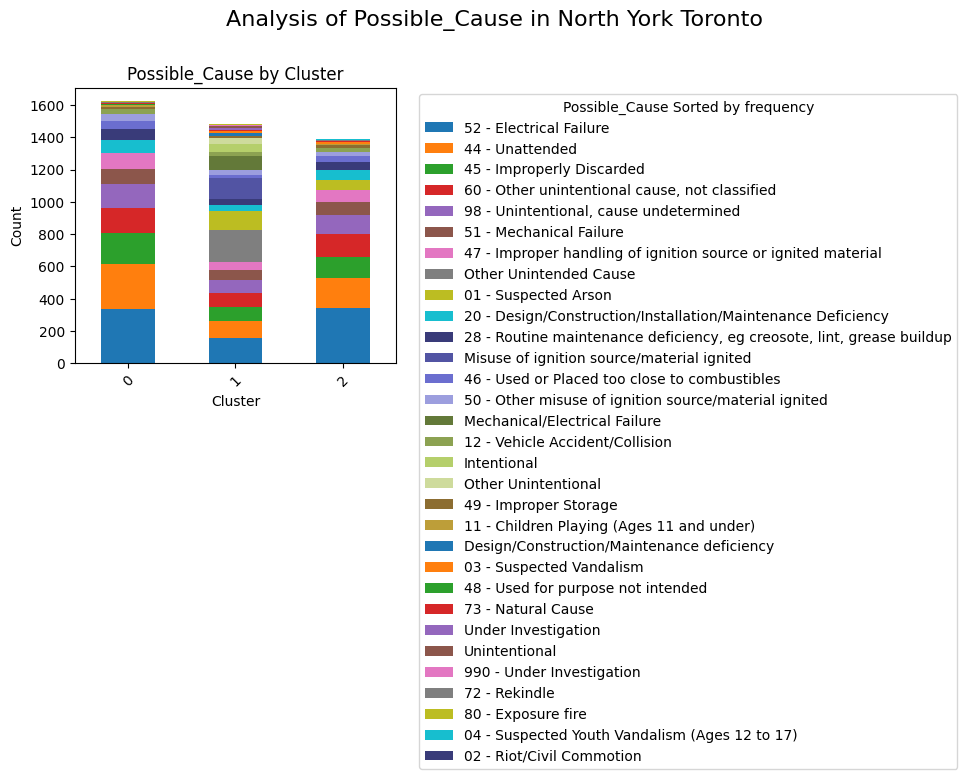

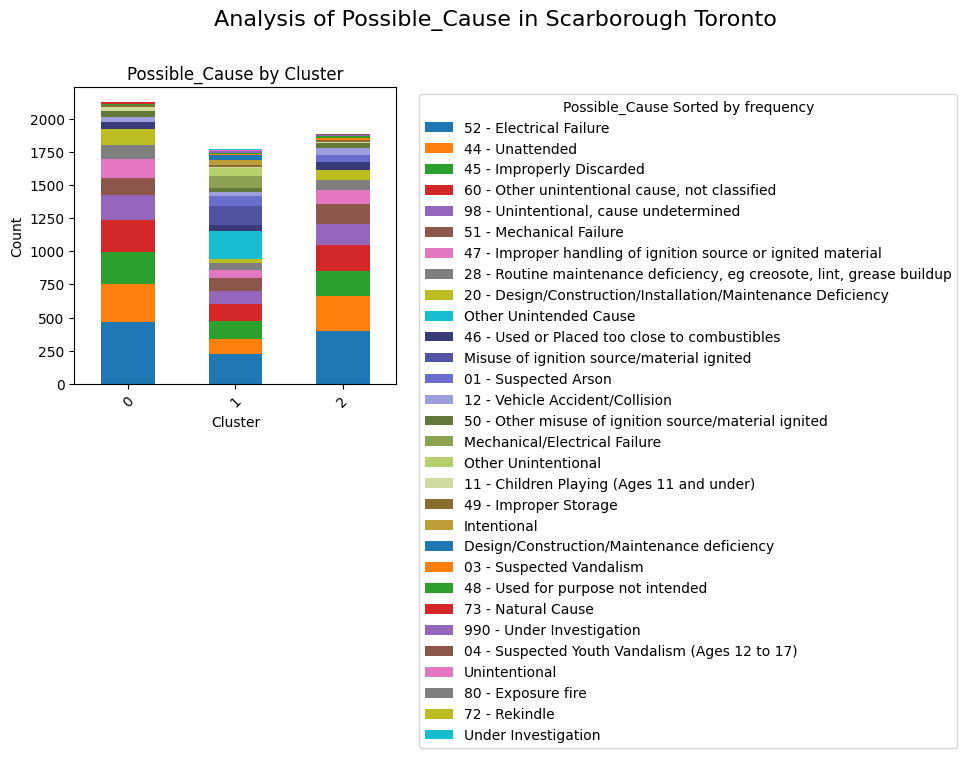

In [19]:
#? This function shows what the most common Possible_Cause of fires is each area and by cluster 

def plot_cause_analysis(df, location_name, cause_column):
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
            '#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939',
            '#8ca252', '#b5cf6b', '#cedb9c', '#8c6d31', '#bd9e39']
    
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle(f'Analysis of {cause_column} in {location_name}', fontsize=16)
    
    # Group by Cluster and 'Possible_Cause' and get the value counts
    cause_counts = df.groupby('Cluster')[cause_column].value_counts().unstack().fillna(0)
    
    # Sort the columns
    sorted_columns = cause_counts.sum().sort_values(ascending=False).index
    cause_counts = cause_counts[sorted_columns]
    
    #Plot
    cause_counts.plot(kind='bar', stacked=True, ax=ax, color=colors)
    ax.set_title(f'{cause_column} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend(title=cause_column+' Sorted by frequency', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Plot cause analysis for each location
plot_cause_analysis(downtown_df, 'Downtown Toronto', 'Possible_Cause')
plot_cause_analysis(north_york_df, 'North York Toronto', 'Possible_Cause')
plot_cause_analysis(scarborough_df, 'Scarborough Toronto', 'Possible_Cause')


## 7. Fire department response analysis for each area by cluster ->

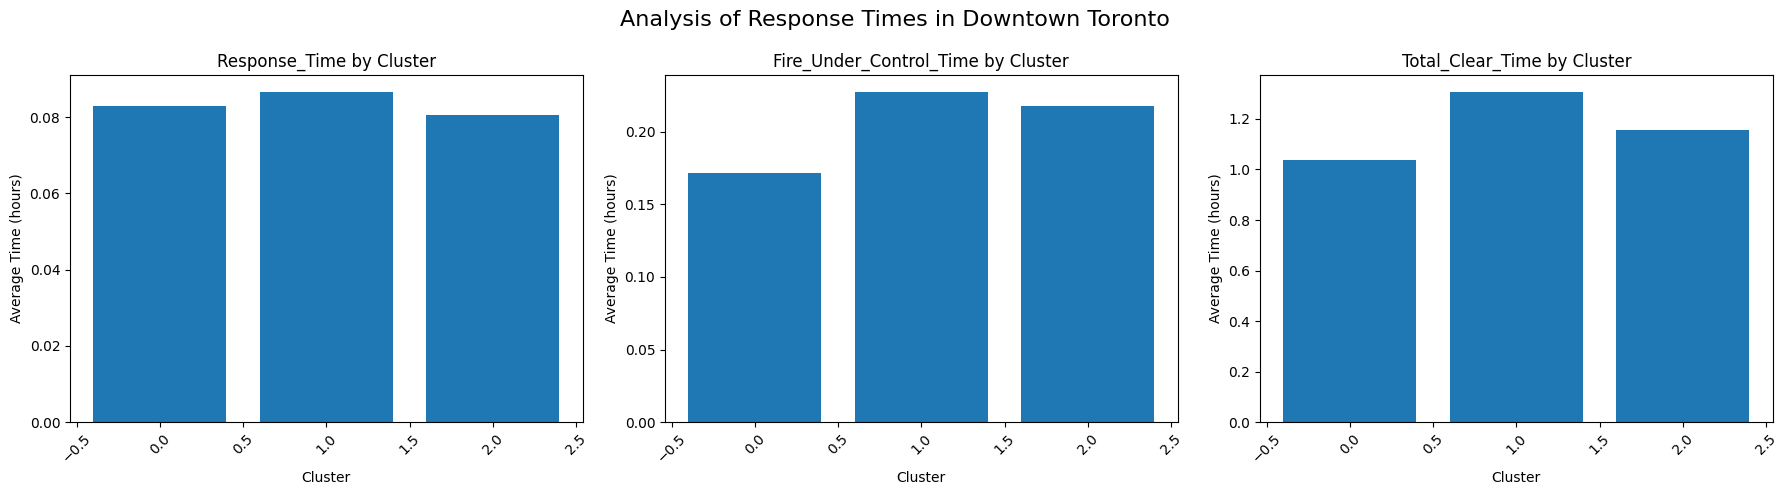

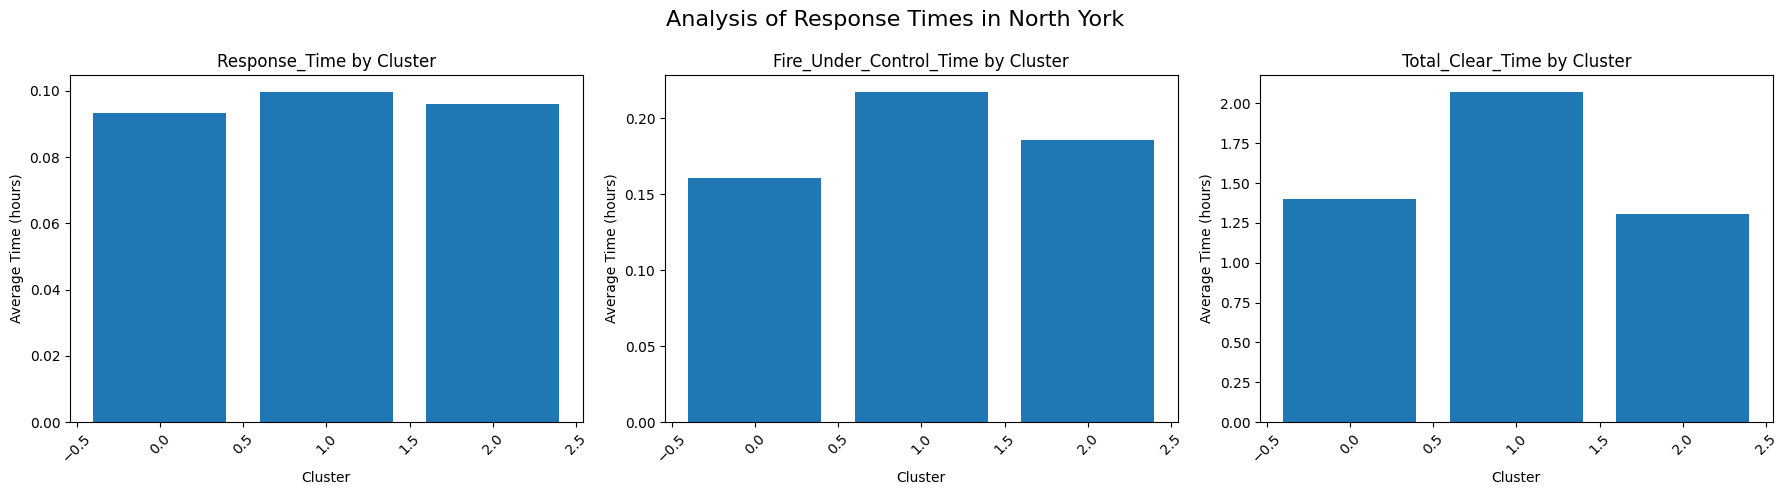

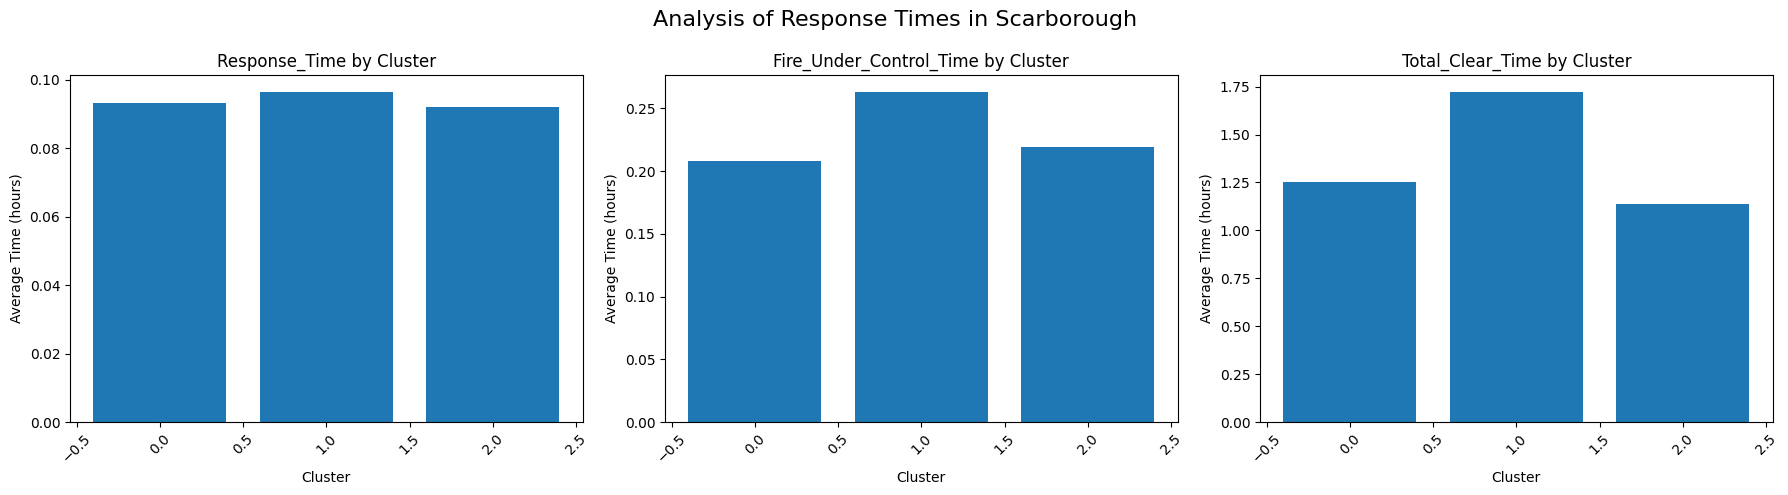

In [20]:
# Calculate the metrics for each fire dept
def calculate_response_metrics(df):
    df['Response_Time'] = (df['TFS_Arrival_Time'] - df['TFS_Alarm_Time']).dt.total_seconds() / 3600
    df['Fire_Under_Control_Time'] = (df['Fire_Under_Control_Time'] - df['TFS_Arrival_Time']).dt.total_seconds() / 3600
    df['Total_Clear_Time'] = (df['Last_TFS_Unit_Clear_Time'] - df['TFS_Arrival_Time']).dt.total_seconds() / 3600
    return df

downtown_df = calculate_response_metrics(downtown_df)
north_york_df = calculate_response_metrics(north_york_df)
scarborough_df = calculate_response_metrics(scarborough_df)
#---

def plot_response_time_analysis(df, location_name):
    metrics = ['Response_Time', 'Fire_Under_Control_Time', 'Total_Clear_Time']
    fig, axs = plt.subplots(1, len(metrics), figsize=(18, 5))
    fig.suptitle(f'Analysis of Response Times in {location_name}', fontsize=16)

    for i, metric in enumerate(metrics):
        avg_time = df.groupby('Cluster')[metric].mean()
        ax = axs[i]
        ax.bar(avg_time.index, avg_time.values)
        ax.set_title(f'{metric} by Cluster')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('Average Time (hours)')
        ax.tick_params(axis='x', labelrotation=45)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Plot the fire department analysis for each area
plot_response_time_analysis(downtown_df, 'Downtown Toronto')
plot_response_time_analysis(north_york_df, 'North York')
plot_response_time_analysis(scarborough_df, 'Scarborough')

### 6.1 Statistics and comparison of each area's fire department ->

  Cluster Response_Time           Fire_Under_Control_Time            \
                   mean       std                    mean       std   
0       0      0.083014  0.206952                0.171671  0.347722   
1       1      0.086695  0.036283                0.227603  0.640420   
2       2      0.080528  0.028422                0.217873  0.474796   
3       0      0.093284  0.028872                0.160319  0.304517   
4       1      0.099799  0.041048                0.217460  0.364750   
5       2      0.095971  0.114379                0.185621  0.321871   
6       0      0.093095  0.029213                0.207762  0.559534   
7       1      0.096572  0.034402                0.263479  0.756559   
8       2      0.092050  0.032307                0.219216  0.793530   

  Total_Clear_Time                    Location  
              mean       std                    
0         1.037478  1.813030  Downtown Toronto  
1         1.308608  3.776059  Downtown Toronto  
2         1.157051  2.

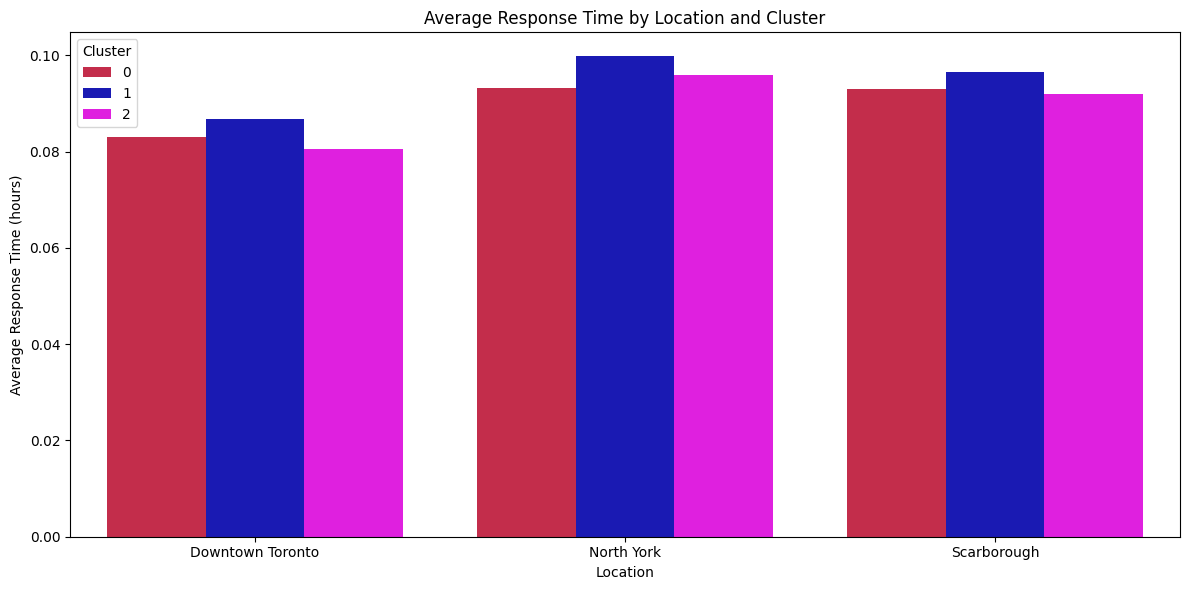

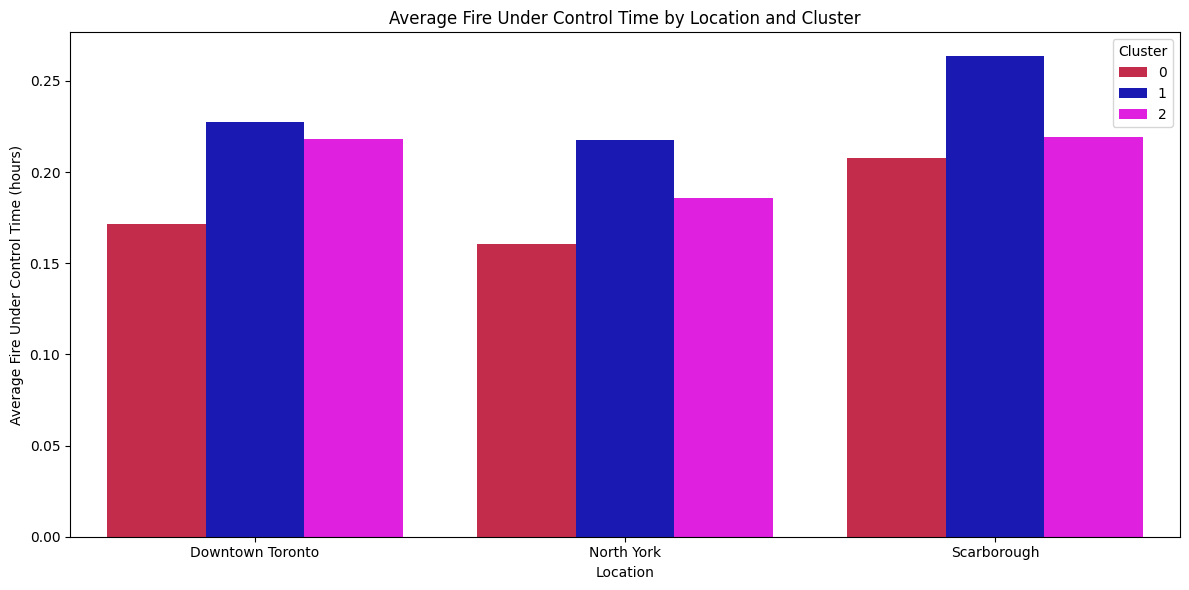

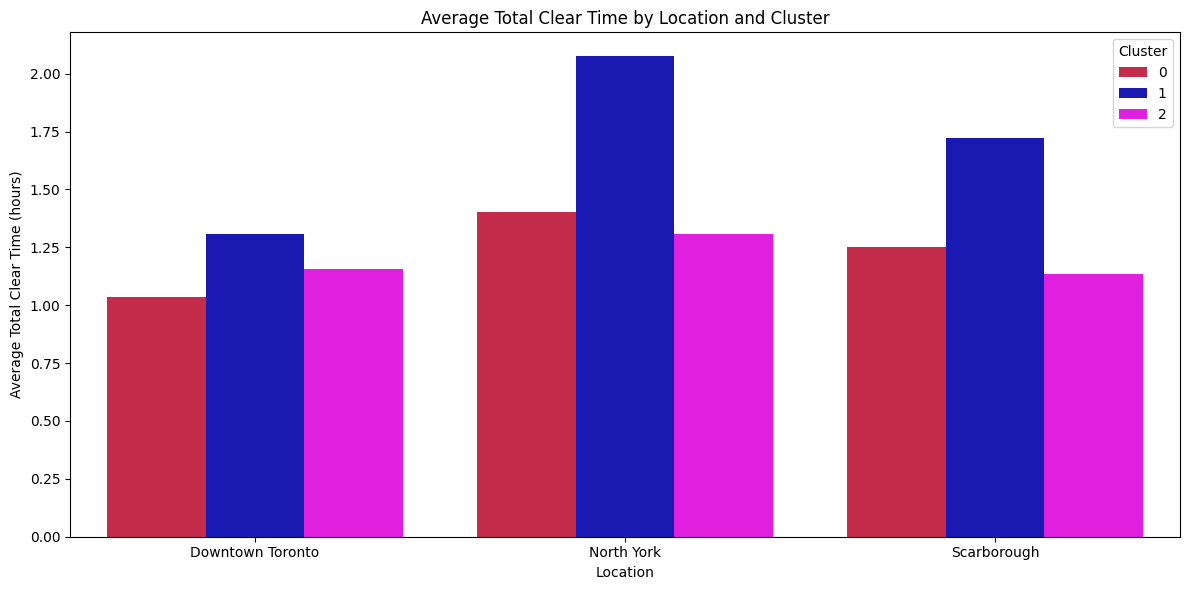

In [21]:
# Each row in downtown_stats corresponds to one cluster identified 
# in the downtown_df DataFrame. Since downtown_df was clustered into 
# 3 distinct groups (clusters), downtown_stats will have 3 rows—one for each cluster.

# Calculating mean and standard deviation for ['Response_Time', 'Fire_Under_Control_Time', 'Total_Clear_Time']
def calculate_summary_statistics(df, location_name):
    metrics = ['Response_Time', 'Fire_Under_Control_Time', 'Total_Clear_Time']
    summary_stats = df.groupby('Cluster')[metrics].agg(['mean', 'std']).reset_index()
    summary_stats['Location'] = location_name
    return summary_stats

downtown_stats = calculate_summary_statistics(downtown_df, 'Downtown Toronto')
north_york_stats = calculate_summary_statistics(north_york_df, 'North York')
scarborough_stats = calculate_summary_statistics(scarborough_df, 'Scarborough')

all_stats = pd.concat([downtown_stats, north_york_stats, scarborough_stats], ignore_index=True)
print(all_stats)
#---

def plot_comparison_analysis(stats, metric):
    customcmap = ListedColormap(["crimson", "mediumblue", "magenta"])
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(data=stats, x='Location', y=(metric, 'mean'), hue='Cluster', ax=ax, palette=customcmap.colors)
    ax.set_title(f'Average {metric.replace("_", " ")} by Location and Cluster')
    ax.set_xlabel('Location')
    ax.set_ylabel(f'Average {metric.replace("_", " ")} (hours)')
    ax.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

# Plotting for each metric
plot_comparison_analysis(all_stats, 'Response_Time')
plot_comparison_analysis(all_stats, 'Fire_Under_Control_Time')
plot_comparison_analysis(all_stats, 'Total_Clear_Time')

## 8. Training a Random Forest Regressor to find the approximate 'safety from fire incidents' of each area 

The mean safety score for Downtown is 24140.58
The mean safety score for North York is 28537.99
The mean safety score for Scarborough is 39668.99


/tmp/ipykernel_5992/1110186385.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(location_means.keys()), y=list(location_means.values()), ax=ax, palette='viridis')


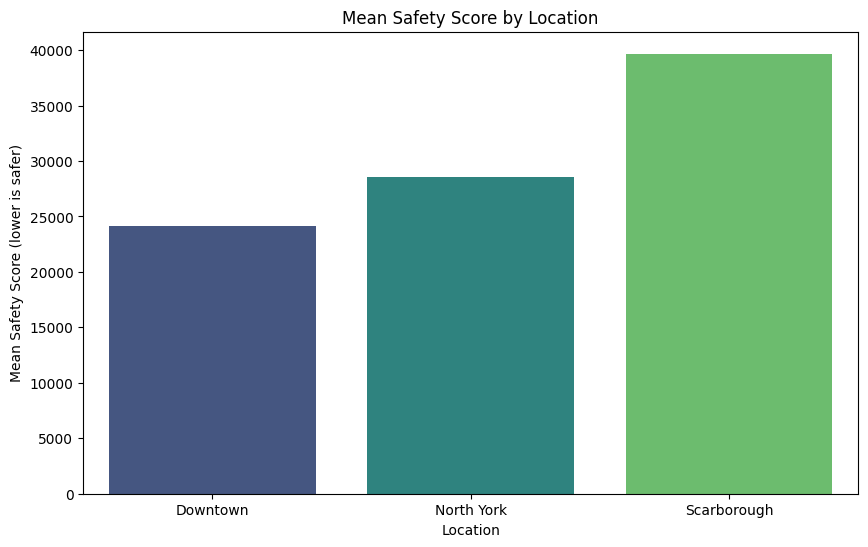

In [22]:
def process_and_train_model(dataframes, locations, categorical_columns, input_columns):
    
    location_means = {}
    for df, location_name in zip(dataframes, locations):
        
        # Calculate safety score
        df['Safety_Score'] = df['Response_Time'] + df['Fire_Under_Control_Time'] + df['Total_Clear_Time'] + df['Civilian_Casualties'] + df['Estimated_Dollar_Loss']
        
        # Encode categorical data
        for col in categorical_columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
        
        # Prepare to train
        X = df[input_columns]
        y = df['Safety_Score']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Remove NaN values
        train_na_mask = y_train.notna()
        X_train = X_train[train_na_mask]
        y_train = y_train[train_na_mask]

        test_na_mask = y_test.notna()
        X_test = X_test[test_na_mask]
        y_test = y_test[test_na_mask]
        
        # Train the Random Forest Regressor
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        # Calculate mean safety score
        mean_safety_score = df['Safety_Score'].mean()
        location_means[location_name] = mean_safety_score
        print(f"The mean safety score for {location_name} is {mean_safety_score:.2f}")
    
    return location_means

# Define dataframes and their respective locations
dataframes = [downtown_df, north_york_df, scarborough_df]
locations = ['Downtown', 'North York', 'Scarborough']
categorical_columns = ['Possible_Cause','Fire_Alarm_System_Presence', 'Sprinkler_System_Presence']  
input_columns = ['Response_Time', 'Fire_Under_Control_Time', 'Total_Clear_Time', 'Civilian_Casualties', 'Estimated_Dollar_Loss', 'Number_of_responding_personnel'] + categorical_columns

# Process data and train models
location_means = process_and_train_model(dataframes, locations, categorical_columns, input_columns)

# Display mean safety scores for each location
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=list(location_means.keys()), y=list(location_means.values()), ax=ax, palette='viridis')
ax.set_title('Mean Safety Score by Location')
ax.set_xlabel('Location')
ax.set_ylabel('Mean Safety Score (lower is safer)')
plt.show()